Ch#9

here I Start to dig into the NanoGPT code construction, how really a simple gpt2 works and how the computing construction insde the code and the myster of transformer network. As I mainly focus on deployment, I will reconstruct sample.py in the nanogpt.

In [23]:
import os
import pickle
from contextlib import nullcontext
import torch
import tiktoken
from model import GPTConfig, GPT


ModuleNotFoundError: No module named 'model'

As listing above, let go through first in the module in different code file and restate here.


The whole model is a implementation of GPT language model, all need to restate here
# To Do: detailed anaysis of structure




In [ ]:
"""
Full definition of a GPT Language Model, all of it in this single file.
References:
1) the official GPT-2 TensorFlow implementation released by OpenAI:
https://github.com/openai/gpt-2/blob/master/src/model.py
2) huggingface/transformers PyTorch implementation:
https://github.com/huggingface/transformers/blob/main/src/transformers/models/gpt2/modeling_gpt2.py
"""

import math
import inspect
from dataclasses import dataclass

import torch
import torch.nn as nn
from torch.nn import functional as F

class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """

    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)

class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        # regularization
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout
        # flash attention make GPU go brrrrr but support is only in PyTorch >= 2.0
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
        if not self.flash:
            print("WARNING: using slow attention. Flash Attention requires PyTorch >= 2.0")
            # causal mask to ensure that attention is only applied to the left in the input sequence
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                        .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        if self.flash:
            # efficient attention using Flash Attention CUDA kernels
            y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True)
        else:
            # manual implementation of attention
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y

class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

@dataclass
class GPTConfig:
    block_size: int = 1024
    vocab_size: int = 50304 # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 768
    dropout: float = 0.0
    bias: bool = True # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster

class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        # with weight tying when using torch.compile() some warnings get generated:
        # "UserWarning: functional_call was passed multiple values for tied weights.
        # This behavior is deprecated and will be an error in future versions"
        # not 100% sure what this is, so far seems to be harmless. TODO investigate
        self.transformer.wte.weight = self.lm_head.weight # https://paperswithcode.com/method/weight-tying

        # init all weights
        self.apply(self._init_weights)
        # apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # report number of parameters
        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))

    def get_num_params(self, non_embedding=True):
        """
        Return the number of parameters in the model.
        For non-embedding count (default), the position embeddings get subtracted.
        The token embeddings would too, except due to the parameter sharing these
        params are actually used as weights in the final layer, so we include them.
        """
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.transformer.wpe.weight.numel()
        return n_params

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss

    def crop_block_size(self, block_size):
        # model surgery to decrease the block size if necessary
        # e.g. we may load the GPT2 pretrained model checkpoint (block size 1024)
        # but want to use a smaller block size for some smaller, simpler model
        assert block_size <= self.config.block_size
        self.config.block_size = block_size
        self.transformer.wpe.weight = nn.Parameter(self.transformer.wpe.weight[:block_size])
        for block in self.transformer.h:
            if hasattr(block.attn, 'bias'):
                block.attn.bias = block.attn.bias[:,:,:block_size,:block_size]

    @classmethod
    def from_pretrained(cls, model_type, override_args=None):
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        override_args = override_args or {} # default to empty dict
        # only dropout can be overridden see more notes below
        assert all(k == 'dropout' for k in override_args)
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        print("forcing vocab_size=50257, block_size=1024, bias=True")
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        config_args['bias'] = True # always True for GPT model checkpoints
        # we can override the dropout rate, if desired
        if 'dropout' in override_args:
            print(f"overriding dropout rate to {override_args['dropout']}")
            config_args['dropout'] = override_args['dropout']
        # create a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model

    def configure_optimizers(self, weight_decay, learning_rate, betas, device_type):
        # start with all of the candidate parameters
        param_dict = {pn: p for pn, p in self.named_parameters()}
        # filter out those that do not require grad
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
        # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
        # Create AdamW optimizer and use the fused version if it is available
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and device_type == 'cuda'
        extra_args = dict(fused=True) if use_fused else dict()
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas, **extra_args)
        print(f"using fused AdamW: {use_fused}")

        return optimizer

    def estimate_mfu(self, fwdbwd_per_iter, dt):
        """ estimate model flops utilization (MFU) in units of A100 bfloat16 peak FLOPS """
        # first estimate the number of flops we do per iteration.
        # see PaLM paper Appendix B as ref: https://arxiv.org/abs/2204.02311
        N = self.get_num_params()
        cfg = self.config
        L, H, Q, T = cfg.n_layer, cfg.n_head, cfg.n_embd//cfg.n_head, cfg.block_size
        flops_per_token = 6*N + 12*L*H*Q*T
        flops_per_fwdbwd = flops_per_token * T
        flops_per_iter = flops_per_fwdbwd * fwdbwd_per_iter
        # express our flops throughput as ratio of A100 bfloat16 peak flops
        flops_achieved = flops_per_iter * (1.0/dt) # per second
        flops_promised = 312e12 # A100 GPU bfloat16 peak flops is 312 TFLOPS
        mfu = flops_achieved / flops_promised
        return mfu

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            # forward the model to get the logits for the index in the sequence
            logits, _ = self(idx_cond)
            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            # optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)

        return idx




The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


# parameter setting 

In [ ]:
# parameter setting 
# -----------------------------------------------------------------------------
init_from = 'gpt2' # either 'resume' (from an out_dir) or a gpt2 variant (e.g. 'gpt2-xl')
out_dir = 'out' # ignored if init_from is not 'resume'
start = "What is the answer to life, the universe, and everything?" # or "<|endoftext|>" or etc. Can also specify a file, use as: "FILE:prompt.txt"
num_samples = 5 # number of samples to draw
max_new_tokens = 100 # number of tokens generated in each sample
temperature = 0.8 # 1.0 = no change, < 1.0 = less random, > 1.0 = more random, in predictions
top_k = 200 # retain only the top_k most likely tokens, clamp others to have 0 probability
seed = 1337
device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1', etc.
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32' or 'bfloat16' or 'float16'
compile = False # use PyTorch 2.0 to compile the model to be faster
# exec(open('configurator.py').read()) # overrides from command line or config file
# -----------------------------------------------------------------------------


# Device setting

In [ ]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)
print(f"🖥️  Device type selected     : {device_type}")
print(f"📦  torch device name        : {torch.cuda.get_device_name() if device_type == 'cuda' else 'CPU'}")
print(f"🧠  Data type (ptdtype)      : {ptdtype}")
print(f"⚙️  Using autocast context   : {ctx.__class__.__name__}")
print(f"✅  TF32 matmul allowed       : {torch.backends.cuda.matmul.allow_tf32}")
print(f"✅  TF32 cudnn allowed        : {torch.backends.cudnn.allow_tf32}")
print(f"🔬  bfloat16 supported        : {torch.cuda.is_bf16_supported() if device_type == 'cuda' else 'N/A'}")

🖥️  Device type selected     : cuda
📦  torch device name        : NVIDIA T600 Laptop GPU
🧠  Data type (ptdtype)      : torch.bfloat16
⚙️  Using autocast context   : autocast
✅  TF32 matmul allowed       : True
✅  TF32 cudnn allowed        : True
🔬  bfloat16 supported        : True


# Model preset

In [ ]:
# model
if init_from == 'resume':
    # init from a model saved in a specific directory
    ckpt_path = os.path.join(out_dir, 'ckpt.pt')
    checkpoint = torch.load(ckpt_path, map_location=device)
    gptconf = GPTConfig(**checkpoint['model_args'])
    model = GPT(gptconf)
    state_dict = checkpoint['model']
    unwanted_prefix = '_orig_mod.'
    for k,v in list(state_dict.items()):
        if k.startswith(unwanted_prefix):
            state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
    model.load_state_dict(state_dict)
elif init_from.startswith('gpt2'):
    # init from a given GPT-2 model
    model = GPT.from_pretrained(init_from, dict(dropout=0.0))

model.eval()
model.to(device)
if compile:
    model = torch.compile(model) # requires PyTorch 2.0 (optional)

# look for the meta pickle in case it is available in the dataset folder
load_meta = False
if init_from == 'resume' and 'config' in checkpoint and 'dataset' in checkpoint['config']: # older checkpoints might not have these...
    meta_path = os.path.join('data', checkpoint['config']['dataset'], 'meta.pkl')
    load_meta = os.path.exists(meta_path)
if load_meta:
    print(f"Loading meta from {meta_path}...")
    with open(meta_path, 'rb') as f:
        meta = pickle.load(f)
    # TODO want to make this more general to arbitrary encoder/decoder schemes
    stoi, itos = meta['stoi'], meta['itos']
    encode = lambda s: [stoi[c] for c in s]
    decode = lambda l: ''.join([itos[i] for i in l])
else:
    # ok let's assume gpt-2 encodings by default
    print("No meta.pkl found, assuming GPT-2 encodings...")
    enc = tiktoken.get_encoding("gpt2")
    encode = lambda s: enc.encode(s, allowed_special={"<|endoftext|>"})
    decode = lambda l: enc.decode(l)

# encode the beginning of the prompt
if start.startswith('FILE:'):
    with open(start[5:], 'r', encoding='utf-8') as f:
        start = f.read()
start_ids = encode(start)
x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])

loading weights from pretrained gpt: gpt2
forcing vocab_size=50257, block_size=1024, bias=True
overriding dropout rate to 0.0
number of parameters: 123.65M
No meta.pkl found, assuming GPT-2 encodings...


# Runing and Bencharking!

In [ ]:
import time

# run generation and benchmark
with torch.no_grad():
    with ctx:
        start_time = time.time()

        for k in range(num_samples):
            gen_start = time.time()
            y = model.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
            gen_end = time.time()

            gen_time = gen_end - gen_start
            print(f"⏱️ Sample {k+1} | Time: {gen_time:.3f}s | {max_new_tokens} tokens | {gen_time / max_new_tokens * 1000:.2f} ms/token")
            print(decode(y[0].tolist()))
            print('---------------')

        end_time = time.time()
        total_time = end_time - start_time
        avg_time_per_token = total_time / (num_samples * max_new_tokens)

        print(f"\n✅ Benchmark Summary:")
        print(f"Total time: {total_time:.3f} seconds")
        print(f"Average per sample: {total_time / num_samples:.3f} seconds")
        print(f"Average per token: {avg_time_per_token * 1000:.2f} ms/token")
        print(f"Tokens per second: {1.0 / avg_time_per_token:.2f} tokens/s")

⏱️ Sample 1 | Time: 4.797s | 100 tokens | 47.97 ms/token
What is the answer to life, the universe, and everything?

In the beginning God created everything.

At its creation he created and ruled over the elements and the elements were governed by Him. He made life, His creation, and His destiny. He made the world, the universe, and the universe was governed by Him. And the law was applied. The scientists and philosophers were guided, the wise men guided, and the arts guided. God is the law…and the law of the world is the laws of the world.

Thus
---------------
⏱️ Sample 2 | Time: 1.845s | 100 tokens | 18.45 ms/token
What is the answer to life, the universe, and everything?

In the previous post, I argued that the answer is now, for more than two decades, an obvious one. To simplify the arguments, I want to offer a direct response to the claim that there are no answers to the basic question of existence. I've been arguing for a long time that there are no answers to the basic question 

python sample.py --init_from=gpt2 --start="What is the answer to life, the universe, and everything?" --num_samples=5 --max_new_tokens=100 
 
The above initial benchmark will serve as a baseline for me to make comparison later with my optimized hardware.

# Analyze the algorithm!

Recall from previous python Bytecode anaysis process, I decide to follow again to analyze our code using good tools

First I wrap above code into a single whole python file and compile it as bytecode to do more analysis.


In [ ]:
import py_compile

py_compile.compile("Code Analysis/gpt2sample.py")

'Code Analysis\\__pycache__\\gpt2sample.cpython-310.pyc'

In [ ]:
import dis
import marshal

with open('Code Analysis/__pycache__/gpt2sample.cpython-310.pyc', 'rb') as f:

    f.read(16)  # skip the .pyc header (magic number, timestamp, etc.)
    code = marshal.load(f)

dis.dis(code)

  1           0 LOAD_CONST               0 ('\nFull definition of a GPT Language Model, all of it in this single file.\nReferences:\n1) the official GPT-2 TensorFlow implementation released by OpenAI:\nhttps://github.com/openai/gpt-2/blob/master/src/model.py\n2) huggingface/transformers PyTorch implementation:\nhttps://github.com/huggingface/transformers/blob/main/src/transformers/models/gpt2/modeling_gpt2.py\n')
              2 STORE_NAME               0 (__doc__)

 10           4 LOAD_CONST               1 (0)
              6 LOAD_CONST               2 (None)
              8 IMPORT_NAME              1 (math)
             10 STORE_NAME               1 (math)

 11          12 LOAD_CONST               1 (0)
             14 LOAD_CONST               2 (None)
             16 IMPORT_NAME              2 (inspect)
             18 STORE_NAME               2 (inspect)

 12          20 LOAD_CONST               1 (0)
             22 LOAD_CONST               3 (('dataclass',))
             24 IMPO

In [ ]:
import collections
# Count instructions
counter = collections.Counter()
for instr in dis.get_instructions(code):
    counter[instr.opname] += 1

# Print results
for opname, count in counter.most_common():
    print(f"{opname:20s}: {count}")

LOAD_CONST          : 105
LOAD_NAME           : 94
STORE_NAME          : 56
POP_TOP             : 33
LOAD_ATTR           : 25
CALL_FUNCTION       : 21
LOAD_METHOD         : 21
CALL_METHOD         : 21
POP_JUMP_IF_FALSE   : 13
EXTENDED_ARG        : 12
BINARY_SUBSCR       : 11
MAKE_FUNCTION       : 10
DUP_TOP             : 10
JUMP_FORWARD        : 8
IMPORT_NAME         : 7
LOAD_BUILD_CLASS    : 6
CALL_FUNCTION_KW    : 6
POP_BLOCK           : 5
SETUP_WITH          : 4
WITH_EXCEPT_START   : 4
POP_JUMP_IF_TRUE    : 4
RERAISE             : 4
POP_EXCEPT          : 4
IMPORT_FROM         : 3
CONTAINS_OP         : 3
COMPARE_OP          : 3
RETURN_VALUE        : 3
STORE_ATTR          : 2
GET_ITER            : 2
FOR_ITER            : 2
BUILD_SLICE         : 2
JUMP_ABSOLUTE       : 2
BUILD_CONST_KEY_MAP : 1
BUILD_MAP           : 1
DICT_MERGE          : 1
CALL_FUNCTION_EX    : 1
UNPACK_SEQUENCE     : 1
STORE_SUBSCR        : 1
FORMAT_VALUE        : 1
BUILD_STRING        : 1
ROT_TWO             : 1


In [ ]:
import subprocess
import sys

subprocess.check_call([sys.executable, "-m", "pip", "install", "snakeviz"])

0

In [ ]:

import cProfile
from Code_Analysis import gpt2sample

cProfile.run('gpt2sample.main()', filename='profile_output.prof')



c:\Users\15360\anaconda3\envs\nanoGPT\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


loading weights from pretrained gpt: gpt2
forcing vocab_size=50257, block_size=1024, bias=True
overriding dropout rate to 0.0
number of parameters: 123.65M


In [ ]:
import pstats

p = pstats.Stats('profile_output.prof')
p.strip_dirs().sort_stats('cumulative').print_stats(20)

Sat Apr 19 21:39:35 2025    profile_output.prof

         5139763 function calls (4839702 primitive calls) in 18.753 seconds

   Ordered by: cumulative time
   List reduced from 8160 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   3695/1    0.144    0.000   18.757   18.757 {built-in method builtins.exec}
        1    0.047    0.047   18.757   18.757 gpt2sample.py:331(main)
      457    0.012    0.000   12.949    0.028 __init__.py:1(<module>)
        6    0.000    0.000    9.478    1.580 _contextlib.py:113(decorate_context)
        5    0.290    0.058    9.458    1.892 gpt2sample.py:305(generate)
75000/500    0.091    0.000    8.868    0.018 module.py:1732(_wrapped_call_impl)
75000/500    0.148    0.000    8.866    0.018 module.py:1740(_call_impl)
      500    3.362    0.007    8.860    0.018 gpt2sample.py:170(forward)
        1    0.002    0.002    7.903    7.903 gpt2sample.py:206(from_pretrained)
   4509/6    0.025    0.000    

from cprofile output with pstats, definately I found function main, generate, forward, from_pretrained, cost most of the time.


In [ ]:
import subprocess
# Step 2: Launch Snakeviz using subprocess
subprocess.run(["snakeviz", "profile_output.prof"])


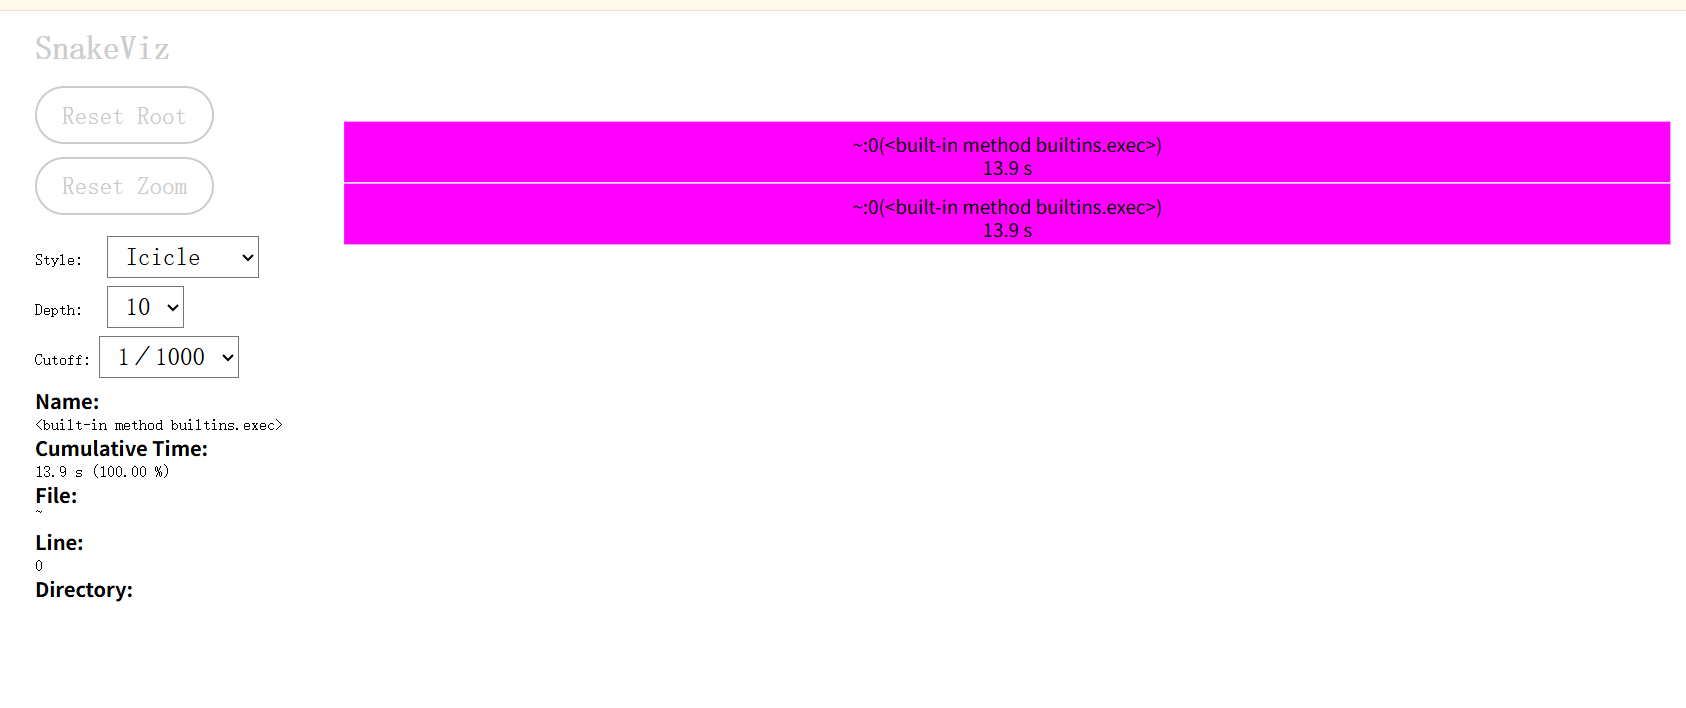

In [ ]:
from IPython.display import Image

Image(filename="gpt2sampleTimer.png")

I think Snake cannot give me enough detail about how I can better see calls and instuctions running time.

Use line profiler!

In [ ]:
# This notebook demonstrates how to profile the GPT2 model using:
# - viztracer for timeline graph
# - line_profiler for line-level profiling
# - torch.profiler for GPU-level insights
# %%
# Setup
!pip install viztracer line_profiler torchviz --quiet


In [ ]:
!kernprof -l -v Code_Analysis/gpt2sample.py


The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.
loading weights from pretrained gpt: gpt2
forcing vocab_size=50257, block_size=1024, bias=True
overriding dropout rate to 0.0
number of parameters: 123.65M
Wrote profile results to gpt2sample.py.lprof
Timer unit: 1e-06 s

Total time: 0.0025259 s
File: Code_Analysis/gpt2sample.py
Function: __init__ at line 21

Line #      Hits         Time  Per Hit   % Time  Line Contents
    21                                               @profile
    22                                               def __init__(self, ndim, bias):
    23        25        444.6     17.8     17.6          super().__init__()
    24        25       1439.5     57.6     57.0          self.weight = nn.Parameter(torch.ones(ndim))
    25        25        641.8     25.7     25.4          self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

Total time: 0.746379 s
File: Code_Analy

analysis from line profile result:

great profile, as it showcase in detail how the line instruction in detail and construction

Then I want to use py-spy to see more about the code struction in flame graph

In [ ]:
!pip install py-spy



   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 1.8/1.8 MB 9.9 MB/s eta 0:00:00


In [ ]:
!py-spy record -o gpt2_flame.svg -- python Code_Analysis/gpt2sample.py


py-spy> Sampling process 100 times a second. Press Control-C to exit.

loading weights from pretrained gpt: gpt2
forcing vocab_size=50257, block_size=1024, bias=True
overriding dropout rate to 0.0
number of parameters: 123.65M

py-spy> Stopped sampling because process exited
py-spy> Wrote flamegraph data to 'gpt2_flame.svg'. Samples: 2030 Errors: 22


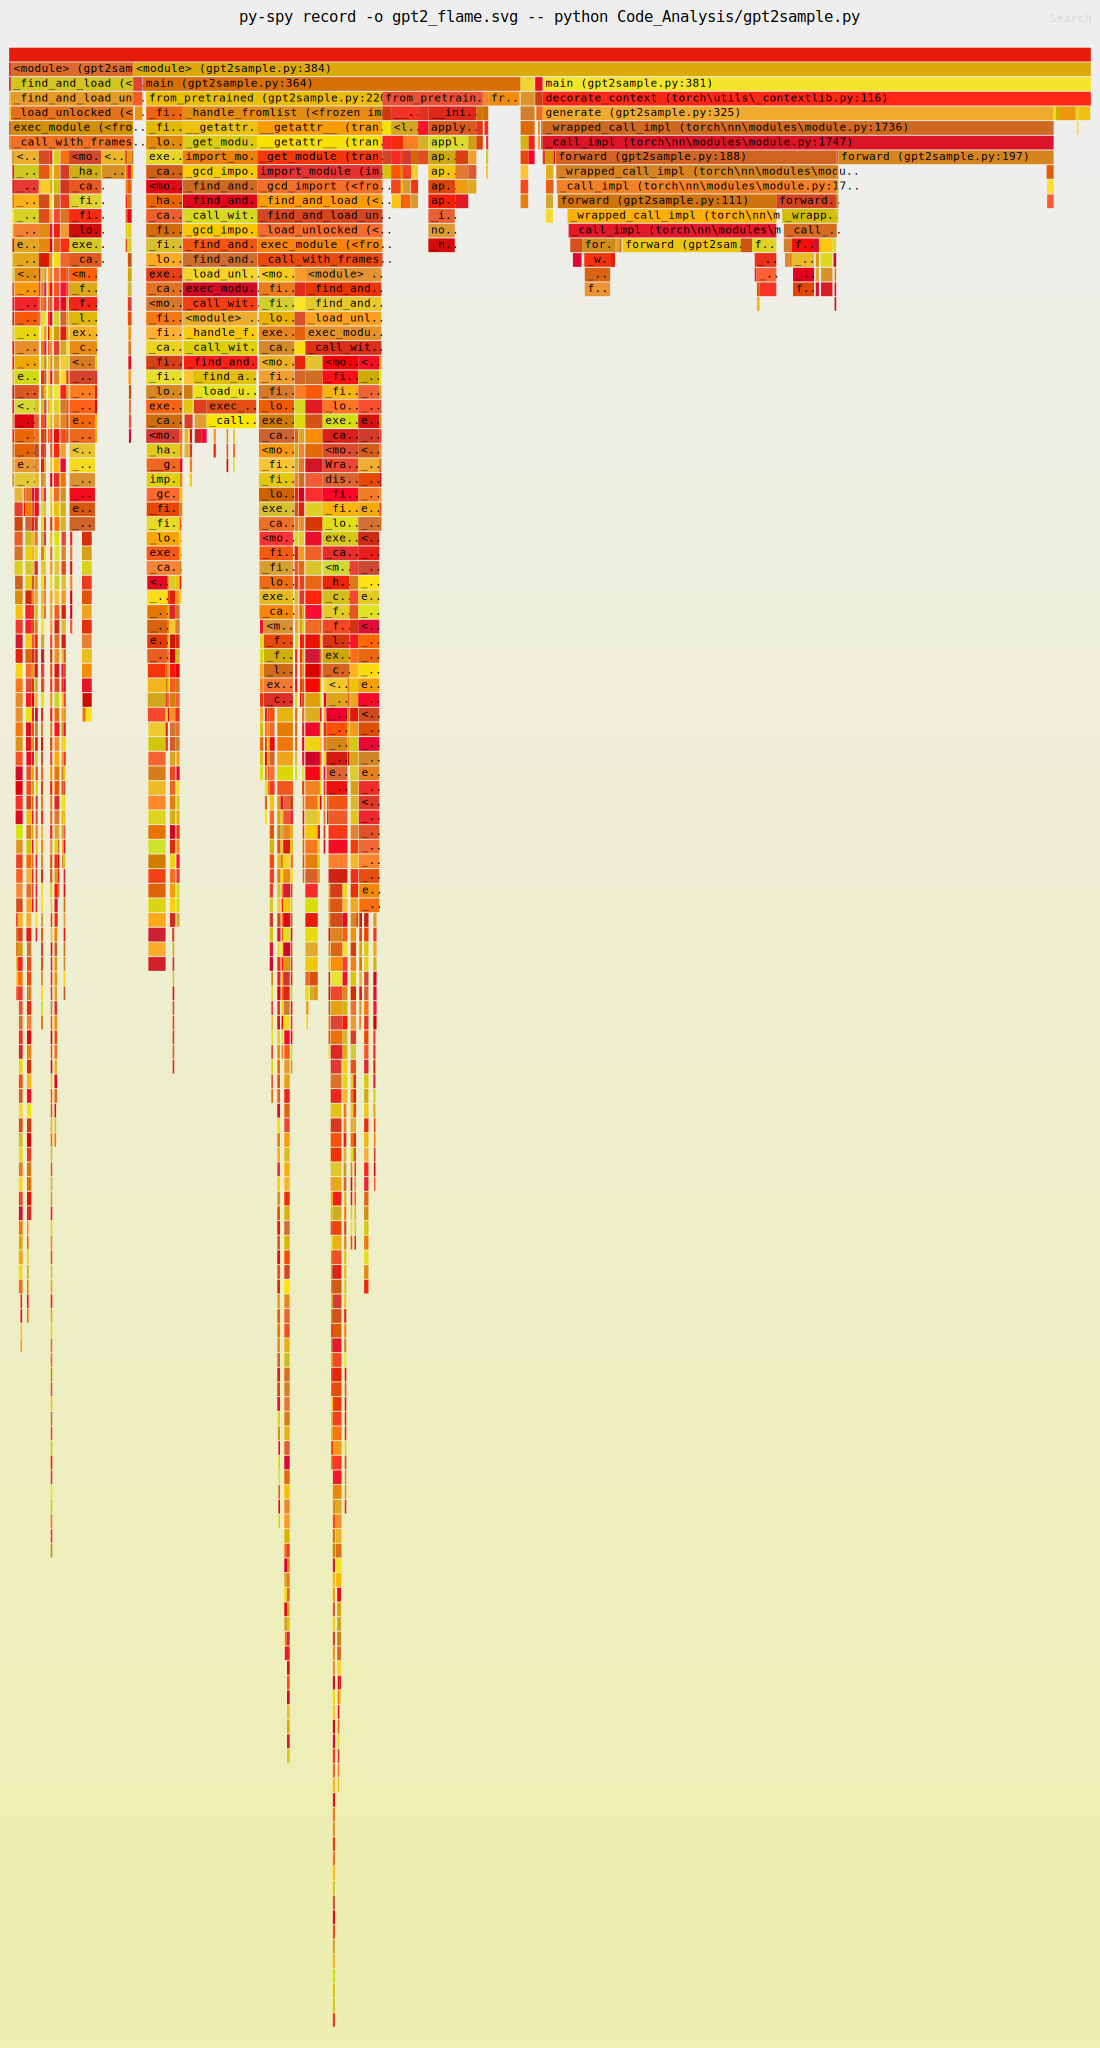

In [ ]:
from IPython.display import SVG, display

# Show the flame graph inside the notebook
display(SVG(filename="gpt2_flame.svg"))


Py-spy's analysis truly impressive me a lot, as it exactly showed how the construct runs and what is the detailed called function, even hidden module in the libarary! 

as above, line-profile give me detailed time excuted line by line and time we hit the line. The py-spy allows us to gain more insight about how really the code run, which part is in parallal and how the persentage the time occupy, and what's more, even detailed what module it calls most. 

For our gpt model, we can see we take some time to load the model! It occupy some time! Then we do acctual computation after through our code in function generator then mainly go into the forward and deep into the pytorch code as expected.

Then yeah! Loading take loads of time. I assume the loading from memory operation will be huge. Then we do memory operation analysis.

In [ ]:
!pip install memory-profiler

In [ ]:
!python -m memory_profiler Code_Analysis/gpt2sample.py



loading weights from pretrained gpt: gpt2
forcing vocab_size=50257, block_size=1024, bias=True
overriding dropout rate to 0.0
number of parameters: 123.65M
Filename: Code_Analysis/gpt2sample.py

Line #    Mem usage    Increment  Occurrences   Line Contents
   219    452.0 MiB    452.0 MiB           1       @classmethod
   220                                             @profile
   221                                             def from_pretrained(cls, model_type, override_args=None):
   222    452.0 MiB      0.0 MiB           1           assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
   223    452.0 MiB      0.0 MiB           1           override_args = override_args or {} # default to empty dict
   224                                                 # only dropout can be overridden see more notes below
   225    452.0 MiB      0.0 MiB           5           assert all(k == 'dropout' for k in override_args)
   226    536.4 MiB     84.4 MiB           1           f

In [ ]:
!pip install matplotlib


  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   -------------------------- ------------- 5.2/8.1 MB 26.6 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 25.0 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 24.9 MB/s eta 0:00:00


ERROR: Could not install packages due to an OSError: [Errno 28] No space left on device



In [ ]:
!mprof run Code_Analysis/gpt2sample.py
!mprof plot


mprof: Sampling memory every 0.1s
running new process
running as a Python program...
loading weights from pretrained gpt: gpt2
forcing vocab_size=50257, block_size=1024, bias=True
overriding dropout rate to 0.0
number of parameters: 123.65M
Filename: Code_Analysis/gpt2sample.py

Line #    Mem usage    Increment  Occurrences   Line Contents
   219    451.6 MiB    451.6 MiB           1       @classmethod
   220                                             @profile
   221                                             def from_pretrained(cls, model_type, override_args=None):
   222    451.6 MiB      0.0 MiB           1           assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
   223    451.6 MiB      0.0 MiB           1           override_args = override_args or {} # default to empty dict
   224                                                 # only dropout can be overridden see more notes below
   225    451.6 MiB      0.0 MiB           5           assert all(k == 'drop

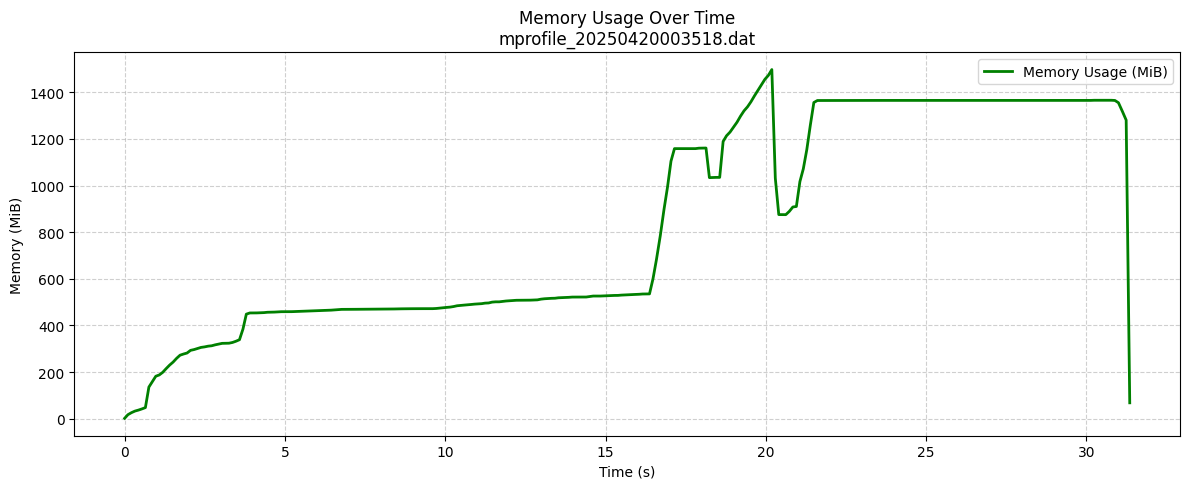

In [ ]:
import matplotlib.pyplot as plt
import os

dat_files = [f for f in os.listdir() if f.startswith("mprof") and f.endswith(".dat")]
latest_file = max(dat_files, key=os.path.getctime)

times = []
memories = []

with open(latest_file, "r") as f:
    for line in f:
        if line.startswith("MEM"):
            parts = line.strip().split()
            memory = float(parts[1])
            timestamp = float(parts[2])
            memories.append(memory)
            times.append(timestamp)

t0 = times[0]
rel_times = [t - t0 for t in times]

plt.figure(figsize=(12, 5))
plt.plot(rel_times, memories, color="green", linewidth=2, label="Memory Usage (MiB)")
plt.xlabel("Time (s)")
plt.ylabel("Memory (MiB)")
plt.title(f"Memory Usage Over Time\n{latest_file}")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
!choco install doxygen.install graphviz     # Windows (using Chocolatey) - you may need to run it through a administation mode

^C


In [ ]:
import os
os.chdir("Code_Analysis")
! "C:/Program Files/doxygen/bin/doxygen.exe" -g




Configuration file 'Doxyfile' created.

Now edit the configuration file and enter

  doxygen

to generate the documentation for your project



In [ ]:
import os

# 目标路径
doxyfile_path = "Doxyfile"

# 修改内容（键值对形式）
updates = {
    "PROJECT_NAME": "GPT2_Analyzer",
    "OUTPUT_DIRECTORY": "docs",
    "INPUT": ".",
    "RECURSIVE": "YES",
    "FILE_PATTERNS": "*.py",
    "EXTENSION_MAPPING": "py=C++",
    "GENERATE_CALL_GRAPH": "YES",
    "CALL_GRAPH": "YES",
    "HAVE_DOT": "YES",
    "DOT_PATH": '"C:/Program Files/Graphviz/bin"',
    "DOT_FONTNAME": '"Arial"',
    "EXTRACT_ALL": "YES",
    "QUIET": "YES"
}

# 读取并修改内容
with open(doxyfile_path, "r", encoding="utf-8") as f:
    lines = f.readlines()

new_lines = []
for line in lines:
    stripped = line.strip()
    if stripped == "" or stripped.startswith("#"):
        new_lines.append(line)
        continue

    key = stripped.split()[0]
    if key in updates:
        new_lines.append(f"{key.ljust(25)}= {updates[key]}\n")
    else:
        new_lines.append(line)

# 保存修改后的文件
with open(doxyfile_path, "w", encoding="utf-8") as f:
    f.writelines(new_lines)

print("✅ Doxyfile updated successfully.")


✅ Doxyfile updated successfully.


In [ ]:
! "C:/Program Files/doxygen/bin/doxygen.exe" Doxyfile


In [ ]:
cleaned_lines = []
with open("Doxyfile", "r", encoding="utf-8") as f:
    for line in f:
        # 去掉奇怪的注释和 markdown 语法行
        if line.strip().startswith(("*", ".", "#", "+")):
            continue
        cleaned_lines.append(line)

with open("Doxyfile", "w", encoding="utf-8") as f:
    f.writelines(cleaned_lines)

print("✅ Cleaned Doxyfile from weird characters.")


✅ Cleaned Doxyfile from weird characters.


In [ ]:
import webbrowser
webbrowser.open("docs/html/index.html")


True

However, as I can tell I only generate garbage throught the process of doxygen. I don't know if I happen to run it in a wrong way, but it is a good trial. But yeah it also makes no sense as it didn't even go through the code to anlyze? I am confused about this part.


As I found not all the recommend methods are as useful as expected, I asked gpt for some good ways for my special gpt generated code

🔥 Recommendation for You
Here’s a smart progression path for your gpt2sample.py analysis:


Phase	Tool	Purpose
🧱 Basic	line_profiler, py-spy, memory_profiler	✅ Done. You already did this excellently.
🧠 Structure	StaticFG, PYCFG, ast + networkx	To visualize structure and flow
🔍 Deep Dive	CodeQL	For precise data dependencies
⚙️ Dynamic View	PyFlowGraph, torch.fx	For true runtime execution graphs
🧠 Final Thought
For GPT2, combining:

torch.fx (to trace tensor-level forward path),

ast + networkx (for code logic),

mprof or py-spy (for profiling and bottlenecks)

would give you a full picture: structure + data + timing.

# StaticFG
I find installion for the opensource package, GPT's guidance is not always helpful. Better check back to offical desciption to see how really you can set the package and call the libarary the correct way.
For installing the staticFG, I struggled a long time chatting with GPT to get me the correct setup. After checking back the offical desciption under their repo, I manage to achieve the setup of libaray. Check https://github.com/JonathanSalwan/StatiCFG.git to find the correct setup.

In [43]:
# Then use StaticFG to get our code runing # run_staticfg.py
from staticfg import CFGBuilder

cfg = CFGBuilder().build_from_file('GPT_CFG', 'Code_Analysis/gpt2sample.py')
cfg.build_visual('gpt_output', 'pdf')  # will generate example_output.pdf


ImportError: cannot import name 'CFGBuilder' from 'staticfg' (unknown location)

I found I still cannot run file out of Staticfg package folder. Even though I have checked the description and run the demanding line as the README.md file declear. It may be a package path issue that I didn't know how to set. Then I move forward to place my file under the Staticfg folder and finally run the analysis correctly and generate the cool file below:

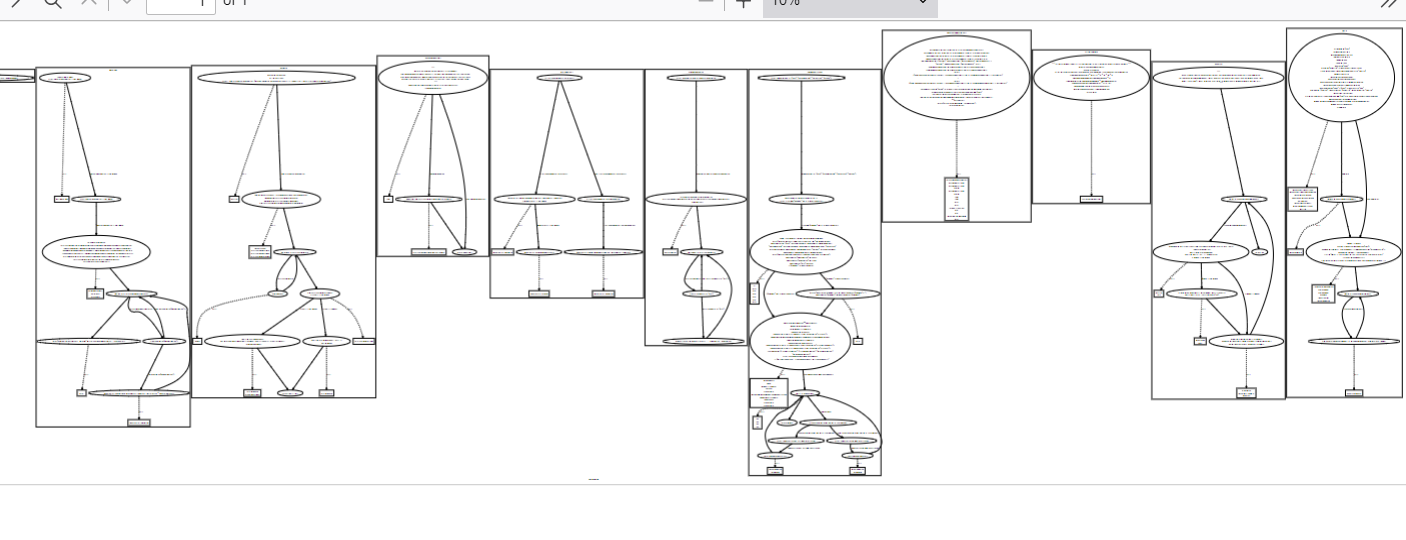

In [49]:
from IPython.display import Image

Image(filename='gpt2_output.png')


# pycallgraph2
another trial: pip install pycallgraph2

I add code below to the code file to do pycall graph2 replace below our code:

In [ ]:
from pycallgraph2 import PyCallGraph
from pycallgraph2.output import GraphvizOutput

if __name__ == "__main__":
    graphviz = GraphvizOutput()
    graphviz.output_file = 'gpt2_callgraph.png'

    with PyCallGraph(output=graphviz):
        main()

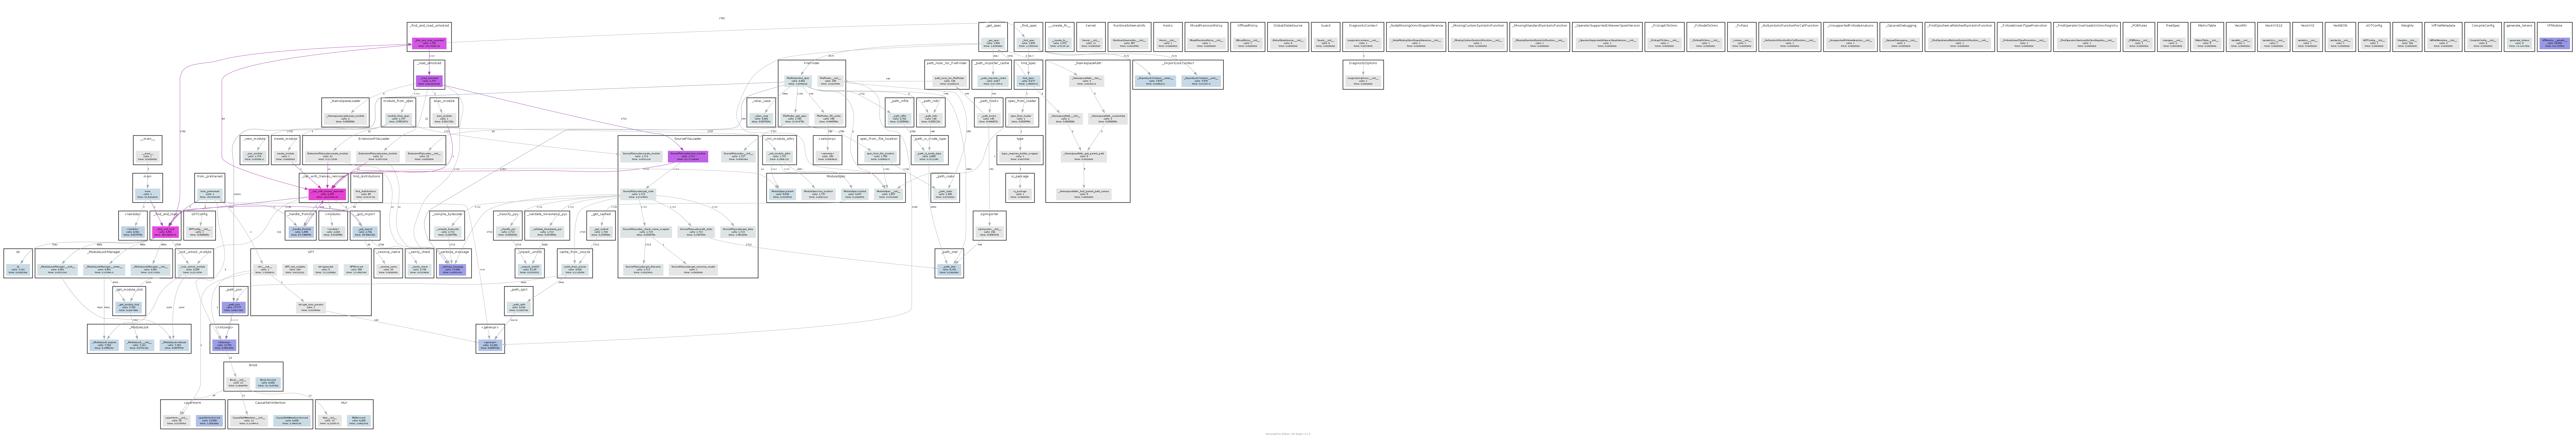

In [50]:
from IPython.display import Image

Image(filename='Code_Analysis/gpt2_callgraph.png')


The above shows everything about the structure, but to me, it does not show anything useful. I think analysis tools make some sense if you know nothing about the code. I found the generated call/control logic diagrams are very detailed, but in reality, the control logic is too fragmented. The blocks are separated from their original code context. I can roughly identify which parts look complex or have a lot of loops, but I still have no clear idea how it actually runs. While tools like pycallgraph2 can generate detailed and visually appealing call graphs of a model like GPT-2, I found that these visualizations often lack truly valuable insight unless you're already unfamiliar with the code. It feels like a waste of time. As a co-design optimizer, we should be capable of structuring the source code logic ourselves. Using LLMs to guide me through profiling tools ends up wasting more time than just learning and analyzing the algorithm and framework directly. These profiling tools are helpful for getting a quick structural overview, but they can't replace manual code tracing and logical reasoning. It's only by going through the code ourselves — understanding the algorithm design, reasoning behind each block, and the flow of data — that we gain insights that are actually useful for co-design and optimization.

So the takeaway from my profiling trial is: we should use profiling tools to quickly get a high-level view of the algorithm — but not rely on them. Often, profiling tools are less effective than going back to the code and understanding the logic directly. In co-design, we ultimately need to return to the algorithm itself. As engineers, we must deeply understand the system — not just depend on profiling outputs.

After using these profiling tools, I got some observations about code timing, memory usage, and runtime structure. But now, we should return to the algorithm and draw a high-level block diagram or flow chart to better understand what we want to optimize, and where the real computational demand is coming from.

# Actual Code Analysis:
In this part, I walk through the source code line by line as excuting with gpt to fully go across the code to make more sense of the code.


Come back to our source code, the logic block of the code would be as follow:
1. Parameter Setup (sampling hyperparameters. They control how many samples, how long, and how randomly to generate text.)
2. Seed + CUDA Precision Setup
3. Device & Precision Context ⚠️ Optimization opportunity: float16 / bf16 brings speedups.
4. Model Loading from pretrained model - ⚠️ It takes times!
5. Tokenizer Setup; Input Preparation Initial input gets tokenized and converted to a batch tensor shape [1, T].
6. Text Generation Loop 📌 This is where the main compute load happens.

1-5 will all be set up in our algurithm, though some part may take time and loads of memory as we observe in previous profiling, they are all one-time setup and cann be cleaned up or refactored for better modularity or quicker experimentation (e.g., config file, CLI args, preset profiles). I think we want to focus more on the real computation part, then we dig more into the 6.Text generation loop.
But first, for setting up the model, why it takes that much time to set up the model? We should also go to take a look at our model Class to make a sense of how really our GPT model construct.
   


We call     model = GPT.from_pretrained(init_from, dict(dropout=0.0)) to fit our model.
Inside the call:

In [ ]:
 def from_pretrained(cls, model_type, override_args=None):
        # Step 1: Model Selection and Config Setup
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        override_args = override_args or {} # default to empty dict
        # only dropout can be overridden see more notes below
        assert all(k == 'dropout' for k in override_args)
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        print("forcing vocab_size=50257, block_size=1024, bias=True")
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        config_args['bias'] = True # always True for GPT model checkpoints
        # we can override the dropout rate, if desired
        if 'dropout' in override_args:
            print(f"overriding dropout rate to {override_args['dropout']}")
            config_args['dropout'] = override_args['dropout']
        # create a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        model = GPT(config) # this will go to set the critical model!




        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model

In [ ]:
# The config in our simple GPT2 task should be:
@dataclass
class GPTConfig:
    block_size: int = 1024
    vocab_size: int = 50304
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 768
    dropout: float = 0.0
    bias: bool = True


# Break down into transformer:
However, I really don't know how a transformer block will act, then I went with GPT to get more sense:
I ask: I know nothing about that, how this really work?
What is a Transformer Block?
A Transformer block is like a processing unit that takes a sequence of vectors and transforms them into a better, more informed representation — one that understands context.


In [ ]:
class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config
#inside GPT model

        #set the transformer
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd), # the Token Embedding layer.
            # turns each token ID (like “cat” = 1234) into a vector of size 768.
            wpe = nn.Embedding(config.block_size, config.n_embd), # the Positional Embedding.
            #  adds a unique vector to each position (1st word, 2nd word, ...), because otherwise the model can't know word order.
            # here we have block size of 1024, indicating our we 1024 different vector(size 768) to characterize as different position
            drop = nn.Dropout(config.dropout),
            #  
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]), # This builds a stack of Transformer blocks.
            # this part create a pytorch list of model, it will call another fuction Block to form each block according to config
            
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))

        # This serve as extracting weight and initialing random weight
        # not 100% sure what this is, so far seems to be harmless. TODO investigate
        self.transformer.wte.weight = self.lm_head.weight # https://paperswithcode.com/method/weight-tying

        # init all weights
        self.apply(self._init_weights)
        # apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # report number of parameters
        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))
# Break down into transformer:



In [ ]:
class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias) # LayerNorms of size n_embd = 768
        # This means each token vector (of length 768) is normalized before attention and MLP.
        self.attn = CausalSelfAttention(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)


    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


The Block Class will also call different function to form different layers, let's go deeper into each part. (Before figuring out how the block construct)

In [ ]:
class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """
    # 
    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        # tensor of shape [ndim], filled with 1.0
        # torch.nn.Parameter is a special kind of tensor
        # Automatically registered as part of the model's parameters.
        # Will be updated by the optimizer during training
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None
        # Creates a tensor of shape [ndim] filled with 0s.
        # bias here serve as a trick for Slightly improving training...
    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)
        # F.layer_norm(...) is Torch’s functional version of nn.LayerNorm
        # input tensor would be [batch_size, seq_len, ndim] = [B, T, 768]
        # self.weight.shape would be size of our weight, in our case is 768
        # self.weight just weight
        # 
        # all in all norm does:


### 📐 Layer Normalization Equation

For each input token vector:
\[
x = [x_1, x_2, \ldots, x_{768}]
\]

---

#### 1. Compute the mean:
\[
\mu = \frac{1}{768} \sum_{i=1}^{768} x_i
\]

---

#### 2. Compute the variance:
\[
\sigma^2 = \frac{1}{768} \sum_{i=1}^{768} (x_i - \mu)^2
\]

---

#### 3. Normalize:
\[
\hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}}
\]

---

#### 4. Apply learnable scale and shift:
\[
y_i = \gamma_i \cdot \hat{x}_i + \beta_i
\]

---

Where:

- \( \gamma \in \mathbb{R}^{768} \): learnable scale parameter (`self.weight`)
- \( \beta \in \mathbb{R}^{768} \): learnable shift parameter (`self.bias`)
- \( \epsilon \): a small constant (e.g., \( 1e{-5} \)) to prevent division by zero

Each of these operations is applied **per token** across its feature dimensions (e.g., 768 in GPT-2).


In [ ]:
class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # This ensures that the embedding dimension can be evenly divided into attention heads.
        # In my case n_embd = 768, n_head = 12 - so for each header, I will assign 64 for different header
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        # QKV Projection Layer 
        # a single linear layer that computes: Q (Query); K (Key); V (Value)
        # Instead of doing 3 separate projections, this layer outputs:
        # [x_Q; x_K; x_V]  ← shape: (B, T, 3 × 768)

        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        # Output Projection： After attention is calculated, all head outputs are concatenated back to shape (B, T, 768)
        # 

        # regularization
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        # config.dropout = 0.0； so my implementation don't have to worry about this 
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout
        # flash attention make GPU go brrrrr but support is only in PyTorch >= 2.0
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
        if not self.flash:
            print("WARNING: using slow attention. Flash Attention requires PyTorch >= 2.0")
            # causal mask to ensure that attention is only applied to the left in the input sequence
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                        .view(1, 1, config.block_size, config.block_size))
        # the self.flash could be an issue

    def forward(self, x):
        # Input Shape Extraction
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        # as we previously discussion in Class, the cacluation of qkv form together, then split the value

        # Reshape and Transpose
        # Each head gets 64 dim if C=768
        #
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        # reshape into (B, T, 12, 64) (B, T, n_head, head_size)
        # But attention needs: (B, n_head, T, head_size) then .transpose(1, 2) swap axes 1 and 2

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        if self.flash:
            # efficient attention using Flash Attention CUDA kernels
            y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True)
        else:
            # manual implementation of attention
            # swap gives (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T) 
            # q @ k.T: Dot product between queries and keys
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            # Apply Causal Mask
            # Each token can only see itself and previous tokens (no future)
            # [1 0 0 0
            #  1 1 0 0
            #  1 1 1 0
            #  1 1 1 1]
            att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
            # .view(B, T, C)  # (B, T, nh × hs) → (B, T, 768)
        # output projection
        y = self.resid_dropout(self.c_proj(y))
        # (B, T, 768) same format as we input! 
        return y


In [ ]:
class MLP(nn.Module):
    # a standard Transformer position-wise feed-forward network.
    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)# token embedding from 768 → 3072,
        self.gelu    = nn.GELU() # applies a nonlinearity (GELU)
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)# then projects it back down to 768.
        self.dropout = nn.Dropout(config.dropout)
        
    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x
    

After digging into each Class, we can come back to our construction of block:

In [ ]:
class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias) # LayerNorms of size n_embd = 768
        # This means each token vector (of length 768) is normalized before attention and MLP.
        self.attn = CausalSelfAttention(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)


    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        # normalize each token; Apply self-attention: output (B, T, 768), 	Add x + residual: output stays (B, T, 768)
        # x goes through attention and is added back in — allowing gradients and information to flow easier.
        x = x + self.mlp(self.ln_2(x))
        # Again, but go through the mlp
        return x
        # x ∈ ℝ^{B × T × C}  # (batch_size, sequence_length, embedding_dim)
        # x → Block → x'
        # After going through one Block, you get:
        # x′ ∈ ℝ^{B × T × C}  # same shape as input
        # But — the contents of x′ are different.
        # They now hold richer, more contextualized, transformed representations of the tokens.
        

In [ ]:
# come back to state our multi-block building
 nn.ModuleList([Block(config) for _ in range(config.n_layer)]), # This builds a stack of Transformer blocks.
    # this part create a pytorch list of model, it will call another fuction Block to form each block according to config
    # x0 → Block1 → x1 → Block2 → x2 → ... → Block12 → x_final
    # Tokens are refined; Relationships between them are deepened
    # But shape never changes — always (B, T, 768)


In [ ]:
        model = GPT(config) # this will go to set the critical model!

#         This creates a new instance of your custom GPT class, initialized from scratch.

# At this point:

# The model has random weights

# It has the correct architecture, but knows nothing

# 🧠 We need to load the pretrained GPT-2 weights next.
# after initial configing our model, we move on:

        # declear more：

        sd = model.state_dict()

        # load the weight from model

        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param
        # Each key in sd is the name of a parameter, like:
        # 'transformer.h.0.attn.c_attn.weight'
        # This filters out non-learnable stuff (e.g., the buffer mask).

        # We now have a list of trainable parameter names from your model that we want to load into.  

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)

        sd_hf = model_hf.state_dict()


        # all below code for Matching layout
        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model

In [ ]:
# above we finish the load_pretrain, then we move to 

# Puts the model in evaluation mode
# must do this before using the model to generate or evaluate.
 model.eval().to(device)
    if compile:
        model = torch.compile(model) # torch.compile() Traces your model; Can significantly speed up inference and training? But how?

    import tiktoken
# Loads the GPT-2 tokenizer from tiktoken — it maps text ↔ token IDs using GPT-2’s vocabulary and BPE rules.
    enc = tiktoken.get_encoding("gpt2")
    encode = lambda s: enc.encode(s, allowed_special={"<|endoftext|>"})
    decode = lambda l: enc.decode(l)
# Define encode/decode functions
    start = "What is the answer to life, the universe, and everything?"
    start_ids = encode(start)
# wrap input
    x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])

    with torch.no_grad():
        with ctx:
            for _ in range(num_samples):
                y = generate_tokens(model, x, max_new_tokens, temperature, top_k)


# autoregressive text generation.
@profile
def generate_tokens(model, x, max_new_tokens, temperature, top_k):
    return model.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)

 def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]



            # forward the model to get the logits for the index in the sequence
            logits, _ = self(idx_cond)


# inside forwards()
                def forward(self, idx, targets=None):
                    device = idx.device
                    b, t = idx.size()
                    # Read input shape

                    assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
                    pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)
                    # Each token gets a unique position ID
                    # If t = 3, then pos = [0, 1, 2]

                    # forward the GPT model itself
                    tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
                    # word/token embedding (same as lookup table)

                    pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
                    
                    x = self.transformer.drop(tok_emb + pos_emb)
                    # x.shape = (B, T, C)  # example: (1, 3, 768)
                    # (B, T, 768) + (T, 768) = (B, T, 768)
                    for block in self.transformer.h:
                        x = block(x)
                    x = self.transformer.ln_f(x)

                    # if targets is not None:
                    #     # if we are given some desired targets also calculate the loss
                    #     logits = self.lm_head(x)
                    #     loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
                    # else:

                    # inference-time mini-optimization: only forward the lm_head on the very last position
                    logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
                    loss = None
                    # above is only for log

                    return logits, loss


            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            # optionally crop the logits to only the top k options
            #  Apply top-k filtering (optional)
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence and continue adding one and one 
            idx = torch.cat((idx, idx_next), dim=1)

        return idx

In [ ]:
after above digging into the code, I thik I am ready to pose the code diagram
┌────────────────────┐
│ 1. Model Config    │
│ GPTConfig:         │
│  - block_size=1024 │
│  - vocab_size=50304│
│  - n_layer=12      │
│  - n_head=12       │
│  - n_embd=768      │
└────────┬───────────┘
         ↓
┌──────────────────────┐
│ 2. Model Construction│
│  - Token Embedding   │
│  - Positional Embed  │
│  - Transformer Blocks│
│      • LayerNorm     │
│      • SelfAttention │
│      • MLP + Res     │
│  - Final LayerNorm   │
│  - Linear lm_head    │
└────────┬─────────────┘
         ↓
┌─────────────────────────────┐
│ 3. Load Pretrained Weights  │
│  - Match with HF checkpoint │
│  - Transpose where needed   │
└────────┬────────────────────┘
         ↓
┌───────────────────────────────┐
│ 4. Inference Loop (generate)  │
│  Input Prompt → Encode (token IDs) │
│  For each token to generate:       │
│   - Crop context if too long       │
│   - Forward through model          │
│   - Predict next token probs       │
│   - Sample next token              │
│   - Append to prompt               │
└────────┬──────────────────────────┘
         ↓
┌──────────────────────────┐
│ 5. Decode Token Sequence │
│  - Convert back to text  │
│  - Output final string   │
└──────────────────────────┘

We start by building a Transformer-based language model with GPTConfig — specifying depth, width, and vocabulary size.
Then we initialize the model (GPT), which contains embedding layers, a stack of Transformer blocks (each with LayerNorm, Attention, MLP), and a projection head.
We then load pretrained weights from Hugging Face into our custom model.
Once ready, we feed in a prompt, and in each iteration of the generation loop:

We crop context (if needed), forward it through the model, and get token probabilities.

We sample one token, append it to the input, and repeat until we reach the desired output length.
Finally, we decode the token IDs back into text.

GPT2 used to be a hot research topic around, so there has been some great plot showcase the high level structure, I leave it here. 

(Given the time I have spent on this challenge, I may come back if I have time to create my own plots.)


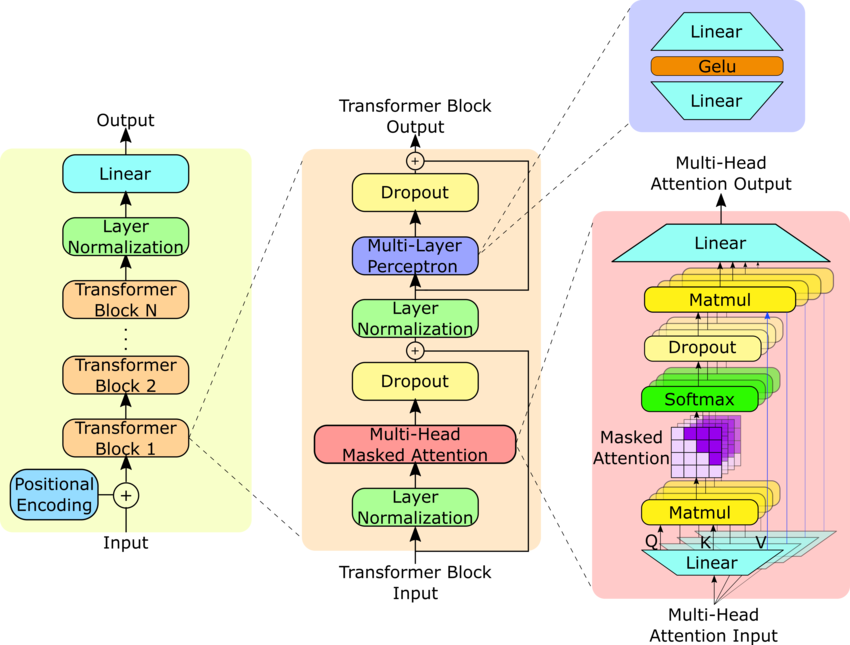

In [55]:
from IPython.display import Image

Image(filename="gpt2_structure.png")

Figure source: adapted from Yang, Steve; Ali, Zulfikhar; and Wong, Bryan. FLUID-GPT (2023): Fast Learning to Understand and Investigate Dynamics with a Generative Pre-Trained Transformer. ChemRxiv. DOI: 10.26434/chemrxiv-2023-ppk9s



# Text Generation Loop
Inside the text generation loop:

I generated a control flow graph for GPT-2 using StaticCFG. It provides a rough overview of the logical structure of each function. However, I noticed that the generated blocks are often fragmented and disconnected from the original code context.

Personally, I believe that truly profiling and understanding code still requires us to go line by line, dig into the core algorithm, and ask GPT (or others) for clarification when needed. The tools help us zoom out, but real understanding comes from working through the logic ourselves.

# Failure: Trial of StaticFG
takeaway: to install the correct package, better come beck to check offical file description, do not trust GPT. GPT will waste your time.


In [ ]:
!git clone https://github.com/coetaur0/staticfg.git
!cd staticfg

fatal: destination path 'staticfg' already exists and is not an empty directory.


In [ ]:
!cd staticfg && python setup.py install


running install
running bdist_egg
running egg_info
creating staticfg.egg-info
writing staticfg.egg-info\PKG-INFO
writing dependency_links to staticfg.egg-info\dependency_links.txt
writing requirements to staticfg.egg-info\requires.txt
writing top-level names to staticfg.egg-info\top_level.txt
writing manifest file 'staticfg.egg-info\SOURCES.txt'
reading manifest file 'staticfg.egg-info\SOURCES.txt'
adding license file 'LICENSE'
writing manifest file 'staticfg.egg-info\SOURCES.txt'
installing library code to build\bdist.win-amd64\egg
running install_lib
running build_py
creating build\lib\staticfg
copying staticfg\builder.py -> build\lib\staticfg
copying staticfg\model.py -> build\lib\staticfg
copying staticfg\__init__.py -> build\lib\staticfg
creating build\bdist.win-amd64\egg
creating build\bdist.win-amd64\egg\staticfg
copying build\lib\staticfg\builder.py -> build\bdist.win-amd64\egg\staticfg
copying build\lib\staticfg\model.py -> build\bdist.win-amd64\egg\staticfg
copying build\lib\

c:\Users\15360\anaconda3\envs\nanoGPT\lib\site-packages\setuptools\_distutils\dist.py:270: UserWarning: Unknown distribution option: 'test_suite'
  warnings.warn(msg)
c:\Users\15360\anaconda3\envs\nanoGPT\lib\site-packages\setuptools\_distutils\cmd.py:79: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
c:\Users\15360\anaconda3\envs\nanoGPT\lib\site-packages\setuptools\_distutils\cmd.py:79: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************

In [ ]:
!pip install -e staticfg


Obtaining file:///D:/AI4Hardware_ECE_410_2025_Spring/Challenge_lists/Challenge%239/Code/Progress/staticfg
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Attempting uninstall: staticfg
    Found existing installation: staticfg 0.9.6
    Uninstalling staticfg-0.9.6:
      Successfully uninstalled staticfg-0.9.6
  Running setup.py develop for staticfg


  DEPRECATION: Legacy editable install of staticfg==0.9.6 from file:///D:/AI4Hardware_ECE_410_2025_Spring/Challenge_lists/Challenge%239/Code/Progress/staticfg (setup.py develop) is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to add a pyproject.toml or enable --use-pep517, and use setuptools >= 64. If the resulting installation is not behaving as expected, try using --config-settings editable_mode=compat. Please consult the setuptools documentation for more information. Discussion can be found at https://github.com/pypa/pip/issues/11457


In [ ]:
code = '''
def test(x):
    if x > 0:
        print("positive")
    else:
        print("non-positive")

for i in range(3):
    test(i)
'''

with open("demo_example.py", "w") as f:
    f.write(code)


In [ ]:
import sys
sys.path.append('./staticfg')  # 添加 staticfg 文件夹到 Python path

from builder import CFGBuilder  # 注意从 builder.py 导入


ModuleNotFoundError: No module named 'builder'

In [ ]:
from staticfg import CFGBuilder

cfg = CFGBuilder().build_from_file('demo', 'demo_example.py')
cfg.build_visual('demo_cfg', 'png')  # 或者 pdf/svg



ImportError: cannot import name 'CFGBuilder' from 'staticfg' (unknown location)

In [ ]:
from staticfg import CFGBuilder

cfg = CFGBuilder().build_from_file("demo", "demo_example.py")
cfg.build_visual("demo_cfg", "png") 



ImportError: cannot import name 'CFGBuilder' from 'staticfg' (unknown location)

In [24]:
!pip install staticfg


In [ ]:
from staticfg.builder import CFGBuilder  



ModuleNotFoundError: No module named 'staticfg.builder'

# above are some garbage generagted by chatgpt, they are useless. Then I decide to move forward to digging into the source code itself to activate the code/


In [33]:
!pip install git+https://github.com/coetaur0/staticfg.git



  Cloning https://github.com/coetaur0/staticfg.git to c:\users\15360\appdata\local\temp\pip-req-build-l9rlytnv
  Resolved https://github.com/coetaur0/staticfg.git to commit ef3172950f459394101fc2cb311d36a2f6eebf6b
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/coetaur0/staticfg.git 'C:\Users\15360\AppData\Local\Temp\pip-req-build-l9rlytnv'


In [35]:
!pip uninstall staticfg -y



Found existing installation: staticfg 0.9.6
Uninstalling staticfg-0.9.6:
  Successfully uninstalled staticfg-0.9.6


In [36]:
!pip install git+https://github.com/coetaur0/staticfg.git


  Cloning https://github.com/coetaur0/staticfg.git to c:\users\15360\appdata\local\temp\pip-req-build-ws64tvpu
  Resolved https://github.com/coetaur0/staticfg.git to commit ef3172950f459394101fc2cb311d36a2f6eebf6b
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for staticfg: filename=staticfg-0.9.6-py3-none-any.whl size=12130 sha256=f6b106ba748873f2403f24763ad2e5ca88cac85d0802c601fa62f2cfc9f24825
  Stored in directory: C:\Users\15360\AppData\Local\Temp\pip-ephem-wheel-cache-tm6v5mbj\wheels\63\78\0c\e093aece2c15ff38c78f9e84e4e7844d966b08a182c0921bbd
Successfully built staticfg


  Running command git clone --filter=blob:none --quiet https://github.com/coetaur0/staticfg.git 'C:\Users\15360\AppData\Local\Temp\pip-req-build-ws64tvpu'


In [38]:
import staticfg
print(staticfg.__file__)


None


In [42]:
import sys
sys.path.append("./staticfg/staticfg")  # 注意是 staticfg 里的 staticfg


In [40]:
from builder import CFGBuilder

cfg = CFGBuilder().build_from_file("demo", "demo_example.py")
cfg.build_visual("demo_cfg", "png")  # 生成 demo_cfg.png 文件


ImportError: attempted relative import with no known parent package